In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from scipy.stats import norm

from keras.datasets import mnist
from keras.optimizers import Adam, RMSprop
from keras.utils import np_utils
from keras import callbacks
from keras import objectives
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Dense, Lambda, merge, Dropout
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras import metrics
from keras import backend as K


import os
import numpy as np
import pandas as pd
import six

import combo

import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
%matplotlib notebook

Using TensorFlow backend.


In [2]:
batch_size = 50
original_dim = 16
latent_dim = 3
intermediate_dim = 1024
intermediate_dim2 = 512
intermediate_dim3 = 256
intermediate_dim4 = 128
epochs = 100
epsilon_std = 1.0
alpha = 0.0 # weight of kl_loss. If alpha = 0, this vae is just an auto-encoder.
target = 'min' # select 'max' or 'min' for optimization
output_dir = '/Users/terayama/Documents/VAE/vamo/result/'

In [3]:
df = pd.read_csv("data/impurity_SiGe.csv")
# df = pd.read_csv("data/impurity_SiSi.csv")
y = df["TC"].as_matrix().astype("float32")
X = df.iloc[:, 0:-1].as_matrix().astype("float32")

index = np.random.permutation(np.arange(X.shape[0]))
Xtest = X[index[0:2000], :]
Xtrain = X [index[2000:], :]
ytest = y[index[0:2000]]

In [4]:
#x = Input(batch_shape=(batch_size, original_dim))
x = Input(shape=(Xtrain.shape[1],))
h = Dense(intermediate_dim, activation='relu')(x)
#h = BatchNormalization()(h)
#h = Dropout(0.2)(h)
h = Dense(intermediate_dim2, activation='relu')(h)
#h = BatchNormalization()(h)
#h = Dropout(0.2)(h)
h = Dense(intermediate_dim3, activation='relu')(h)
#h = BatchNormalization()(h)
#h = Dense(intermediate_dim4, activation='relu')(h)

z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [5]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(latent_dim,), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon


In [6]:
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h4 = Dense(intermediate_dim4, activation='relu')
decoder_h3 = Dense(intermediate_dim3, activation='relu')
#h = BatchNormalization()(h)
decoder_h2 = Dense(intermediate_dim2, activation='relu')
#h = BatchNormalization()(h)
decoder_h = Dense(intermediate_dim, activation='relu')
#h = BatchNormalization()(h)

decoder_mean = Dense(Xtrain.shape[1], activation='sigmoid')
#decoder_mean = Dense(original_dim, activation='sigmoid')
#h_d = decoder_h4(z)
h_d = decoder_h3(z)
h_d = decoder_h2(h_d)
#h_decoded2 = Dropout(0.2)(h_decoded2)
h_d = decoder_h(h_d)
#h_decoded = Dropout(0.2)(h_decoded)

x_decoded_mean = decoder_mean(h_d)


In [7]:
def vae_loss(x, x_decoded_mean): 
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    #kl_loss = 0
    return xent_loss + alpha * kl_loss

In [8]:
vae = Model(x, x_decoded_mean)

#vae.compile(optimizer='rmsprop', loss=vae_loss)


In [9]:
vae.compile(optimizer='adam', loss=vae_loss)

In [10]:
# callback 関数設計
if not os.path.exists("checkpoint"):
    os.makedirs("checkpoint")
    
# Early stopping に関する
es_cb = EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='auto')
cp_cb = ModelCheckpoint(filepath = os.path.join("checkpoint",'vae{epoch:02d}.hdf5'), 
                                              monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cbks = [cp_cb]

In [ ]:
# train the VAE on MNIST digits

history = vae.fit(Xtrain, Xtrain,
        shuffle=True,
        epochs=epochs,
        callbacks=cbks,
        batch_size=batch_size,
        validation_data=(Xtest, Xtest))

Train on 10870 samples, validate on 2000 samples
Epoch 1/100
10870/10870 [==============================] - 13s - loss: 8.8953 - val_loss: 7.7801
Epoch 2/100
10870/10870 [==============================] - 12s - loss: 7.4667 - val_loss: 7.1439
Epoch 3/100
10870/10870 [==============================] - 12s - loss: 6.8155 - val_loss: 6.4762
Epoch 4/100
10870/10870 [==============================] - 11s - loss: 6.2568 - val_loss: 5.8797
Epoch 5/100
10870/10870 [==============================] - 12s - loss: 5.6123 - val_loss: 5.8952
Epoch 6/100
10870/10870 [==============================] - 12s - loss: 5.1673 - val_loss: 4.9929
Epoch 7/100
10870/10870 [==============================] - 14s - loss: 4.9225 - val_loss: 4.7214
Epoch 8/100
10870/10870 [==============================] - 14s - loss: 4.5563 - val_loss: 4.4909
Epoch 9/100
10870/10870 [==============================] - 17s - loss: 4.3805 - val_loss: 4.2263
Epoch 10/100
10870/10870 [==============================] - 16s - loss: 4.2251

In [13]:
# plot loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(1,epochs), loss[1:], marker='.', label='loss')
plt.plot(range(1,epochs), val_loss[1:], marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

NameError: name 'history' is not defined

In [ ]:
#load weights
#vae.load_weights('/Users/terayama/Documents/VAE/vamo/checkpoint/vae93.hdf5')

In [14]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

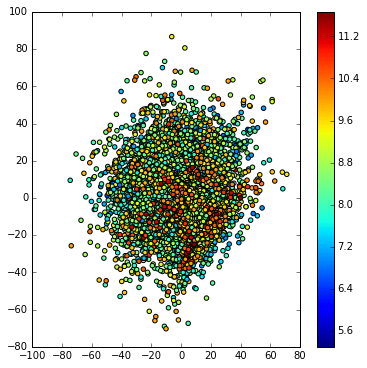

In [15]:
# display a 2D plot of the digit classes in the latent space
%matplotlib inline
Xtest_encoded = encoder.predict(X)
plt.figure(figsize=(6, 6))
plt.scatter(Xtest_encoded[:, 0], Xtest_encoded[:, 1], c=y)
plt.colorbar()

plt.show()

In [16]:
def scatter3d(x,y,z, cs, colorsMap='jet'):
    cm = plt.get_cmap(colorsMap)
    cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure()
    ax = Axes3D(fig)
    # 軸ラベルの設定
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")

    # 表示範囲の設定
    ax.set_xlim(-60, 60)
    ax.set_ylim(-60, 60)
    ax.set_zlim(-60, 60)
    ax.scatter(x, y, z, c=scalarMap.to_rgba(cs))
    scalarMap.set_array(cs)
    fig.colorbar(scalarMap)
    plt.show()

<IPython.core.display.Javascript object>


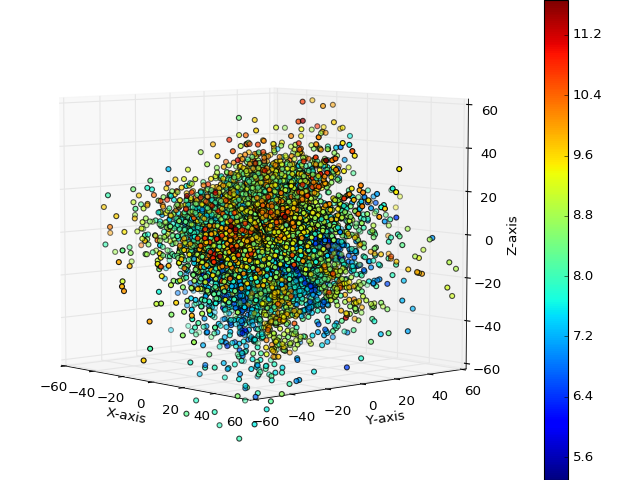

In [17]:
# グラフ作成
from mpl_toolkits.mplot3d import axes3d  
%matplotlib notebook
#scatter3d(Xtest_encoded[:,0], Xtest_encoded[:,1], Xtest_encoded[:,2], y)

colorsMap = 'jet'
cs = y
cm = plt.get_cmap(colorsMap)
cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure()
ax = Axes3D(fig)
# 軸ラベルの設定
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

# 表示範囲の設定
ax.set_xlim(-60, 60)
ax.set_ylim(-60, 60)
ax.set_zlim(-60, 60)
ax.scatter(Xtest_encoded[:,0], Xtest_encoded[:,1], Xtest_encoded[:,2], c=scalarMap.to_rgba(y))
scalarMap.set_array(cs)
fig.colorbar(scalarMap)
plt.show()

In [19]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
#_h_decoded = decoder_h4(decoder_input)
_h_decoded = decoder_h3(decoder_input)
_h_decoded = decoder_h2(_h_decoded)
_h_decoded = decoder_h(_h_decoded)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)


In [20]:
#Map topN values to 1 and the others to 0.
def binarize(vector, topN):
    tmp_v = vector.copy()
    half_value = np.sort(tmp_v)[topN]

    vector[vector >= half_value]=1
    vector[vector < half_value]=0
    return vector

def hamming_dist(vec0, vec1):
    #print(vec0-vec1)
    return np.count_nonzero(vec0!=vec1)

def calc_value(recon):
    t = None
    #for n in six.moves.range(X.shape[0]):
    #    if np.allclose(vec, X[n, :]):
    #        t = y[n]  
    for n in range(X.shape[0]):
        if all(recon == X[n, :]):
            t = y[n]
    return t

In [21]:
#check vae (heavy!)
id = 0

print('Xtest[0]', Xtest[id])
recon_vec = vae.predict(np.array([Xtest[id]]))
print('reconstructed vector:', recon_vec)
print('reconstructed binary vector:', binarize(recon_vec[0], 8))
print('hamming distance:', hamming_dist(Xtest[id], binarize(recon_vec[0], 8)))

test = X
recon_vec = vae.predict(np.array(test))
hamming_list = [hamming_dist(x[0], binarize(x[1], 8)) for x in zip(test, recon_vec)]
print('hamming dist list:', hamming_list)
value_list = [calc_value(recon_vec[n]) if hamming_list[n] == 0 else 10 for n in range(len(recon_vec))]
print('value list:', value_list)
print('min:', np.min(value_list))
print('max:', np.max(value_list))  

Xtest[0] [ 1.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  1.  1.  1.  1.  0.]
reconstructed vector: [[  1.00000000e+00   1.23147930e-18   1.00000000e+00   9.99936461e-01
    1.37948315e-04   1.11818667e-25   6.46513620e-16   6.21830055e-04
    1.00000000e+00   1.90384360e-03   3.57189300e-12   9.99999762e-01
    1.00000000e+00   9.99847531e-01   9.99999762e-01   5.62360624e-14]]
reconstructed binary vector: [ 1.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  1.  1.  1.  1.  0.]
hamming distance: 0
hamming dist list: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [24]:
class simulator:
    def __init__( self ):
        print('initializing...')
        #_, self.t = load_data()
    
    def __call__( self, action):
        vec = generator.predict(Xtest_encoded[action])
        recon = binarize(vec[0], 8)
        print('vec', recon)
    
        sign = 1
        if target == 'min':
            sign = -1
        return sign * calc_value(recon)

In [25]:
# Design of policy

# Declaring the policy by 
policy = combo.search.discrete.policy(test_X=Xtest_encoded)
# test_X is the set of candidates which is represented by numpy.array.
# Each row vector represents the feature vector of the corresponding candidate

# set the seed parameter 
policy.set_seed( 0 )

In [26]:
%matplotlib inline

res = policy.random_search(max_num_probes=20, simulator=simulator())

res = policy.bayes_search(max_num_probes=980, simulator=simulator(), score='TS', 
                                                  interval=20, num_rand_basis=7000)

initializing...
vec [ 0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  0.  0.  0.  1.  1.  0.]
0001-th step: f(x) = -7.566976 (action=12387)
   current best f(x) = -7.566976 (best action=12387) 

vec [ 1.  0.  0.  1.  1.  0.  0.  0.  1.  1.  1.  1.  0.  0.  0.  1.]
0002-th step: f(x) = -8.119348 (action=5128)
   current best f(x) = -7.566976 (best action=12387) 

vec [ 0.  1.  0.  1.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.]
0003-th step: f(x) = -10.541360 (action=8437)
   current best f(x) = -7.566976 (best action=12387) 

vec [ 0.  1.  0.  0.  0.  0.  0.  1.  0.  1.  1.  1.  0.  1.  1.  1.]
0004-th step: f(x) = -9.880992 (action=9855)
   current best f(x) = -7.566976 (best action=12387) 

vec [ 1.  0.  1.  0.  1.  1.  1.  1.  0.  0.  0.  0.  1.  0.  0.  1.]
0005-th step: f(x) = -8.360063 (action=3819)
   current best f(x) = -7.566976 (best action=12387) 

vec [ 0.  0.  1.  0.  0.  0.  0.  1.  1.  1.  1.  1.  0.  0.  1.  1.]
0006-th step: f(x) = -8.542574 (action=11552)
   current best 

In [ ]:
#plot for BO animation
#command example of animation using ffmpeg on Mac
#ffmpeg -r 30 -start_number 60 -i vamo_GeSi_max_%d.png -vcodec libx264 -pix_fmt yuv420p movie.mp4
def shorter(vec):
    l = list(vec)
    l = [int(v*100)/100. for v in l]
    return l
def shortbinary(vec):
    l = list(vec)
    sum = 0
    for i in range(len(l)):
        sum += (10 ** i) * l[len(l) - i]
    return sum
for i in range(0,res.total_num_search):
    
    best_fx, best_action = res.export_all_sequence_best_fx()

    best_pos = Xtest_encoded[best_action[i]]
    best_vec = generator.predict(np.array([best_pos]))
    pos = Xtest_encoded[res.chosed_actions[0:i+1]]
    tmp_value = res.fx[i]
    tmp_pos = Xtest_encoded[res.chosed_actions[i]]
    tmp_vec = generator.predict(np.array([tmp_pos]))

    #----plot3d 
    colorsMap = 'jet'
    cs = res.fx[0:res.total_num_search]
    cm = plt.get_cmap(colorsMap)
    cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure()
    #fig, ax = plt.subplots( figsize=(4, 3))
    ax = Axes3D(fig)
    # 軸ラベルの設定
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")

    # 表示範囲の設定
    ax.set_xlim(-60, 60)
    ax.set_ylim(-60, 60)
    ax.set_zlim(-60, 60)

    ax.scatter(pos[:,0], pos[:,1], pos[:,2], c=scalarMap.to_rgba(res.fx[0:i+1]), depthshade=False)
    scalarMap.set_array(cs)
    fig.colorbar(scalarMap)
    plt.title("round:"+str(i)+" "+target+":"+str(int(1000*best_fx[i])/1000.)+" ("+str(shorter(best_pos))+"\n "+str(list(binarize(best_vec[0], 8)))+")"+"\n"+"tmp:"+str(int(1000*res.fx[i])/1000.)+" ("+str(shorter(tmp_pos))+"\n "+str(list(binarize(tmp_vec[0], 8))))
    #fig.subplots_adjust(left=0.3, bottom=0.05, right=0.95, top=0.95, wspace=0.15, hspace=0.15)
    #
    plt.figsize=(8, 6)
    fig.savefig(output_dir+'vamo_GeSi_'+target+'_'+str(i)+'.png',dpi=200, bbox_inches='tight')
    plt.show()
    plt.clf()
    